# IMPORTS

In [22]:
from keras.preprocessing import image
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras import layers, callbacks, utils, regularizers
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.utils import image_dataset_from_directory
from keras.callbacks import LearningRateScheduler
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os, pathlib, random
import numpy as np
import itertools

keras.utils.set_random_seed(42)

# CONSTANTS

In [4]:
DATASET_DIR = pathlib.Path("../Ro_Sign_language_Dataset")
MODEL_SAVE_DIR = pathlib.Path("/content/drive/MyDrive/Proiect Licenta/Saves/V2")
SAVE_NAME = f'VGG RETRY'

BATCH_SIZE = 64
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
VALIDATION_SPLIT = 0.2
EPOCHS = 50
UNITS = 256

# PREPROCESSING

In [5]:
train_dataset = image_dataset_from_directory(DATASET_DIR / "train",
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             batch_size=BATCH_SIZE,
                                             label_mode='categorical')

validation_dataset = image_dataset_from_directory(DATASET_DIR / "validation",
                                                  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                  batch_size=BATCH_SIZE,
                                                  label_mode='categorical',
                                                  shuffle=False)

test_dataset = image_dataset_from_directory(DATASET_DIR / "test",
                                            image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                            batch_size=BATCH_SIZE,
                                            label_mode='categorical',
                                            shuffle=False)

Found 15600 files belonging to 26 classes.
Found 5200 files belonging to 26 classes.
Found 5200 files belonging to 26 classes.


## ARCHITECTURE

In [6]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet",
                                           include_top=False,
                                           input_shape=(128, 128, 3))

conv_base.summary()

58889256/58889256 [==============================] - 12s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                             

In [7]:
import numpy as np
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 17ms/step


In [8]:
train_features.shape

(15600, 4, 4, 512)

In [9]:
inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(26, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 26)                6682      
                                                                 
Total params: 2,104,090
Trainable params: 2,104,090
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss="categorical_crossentropy",
                 optimizer="adam",
                 metrics=["accuracy"])

In [11]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath = 'adsca.model.keras',
                                             save_best_only=True,
                                             monitor="val_loss")]

history = model.fit(train_features, train_labels,
                    epochs=50,
                    validation_data=(val_features, val_labels),
                    callbacks=callbacks)

np.save('asdxs.history.npy', history.history)

Epoch 1/50
488/488 [==============================] - 3s 5ms/step - loss: 0.6095 - accuracy: 0.9021 - val_loss: 0.7366 - val_accuracy: 0.8527
Epoch 2/50
488/488 [==============================] - 3s 6ms/step - loss: 0.1046 - accuracy: 0.9801 - val_loss: 1.1413 - val_accuracy: 0.8542
Epoch 3/50
488/488 [==============================] - 3s 6ms/step - loss: 0.0977 - accuracy: 0.9837 - val_loss: 1.4970 - val_accuracy: 0.8281
Epoch 4/50
488/488 [==============================] - 4s 9ms/step - loss: 0.0757 - accuracy: 0.9853 - val_loss: 1.6502 - val_accuracy: 0.8692
Epoch 5/50
488/488 [==============================] - 4s 7ms/step - loss: 0.0717 - accuracy: 0.9904 - val_loss: 1.6614 - val_accuracy: 0.8377
Epoch 6/50
488/488 [==============================] - 3s 6ms/step - loss: 0.0816 - accuracy: 0.9883 - val_loss: 2.4722 - val_accuracy: 0.8175
Epoch 7/50
488/488 [==============================] - 4s 8ms/step - loss: 0.1078 - accuracy: 0.9846 - val_loss: 1.5587 - val_accuracy: 0.8471
Epoch 

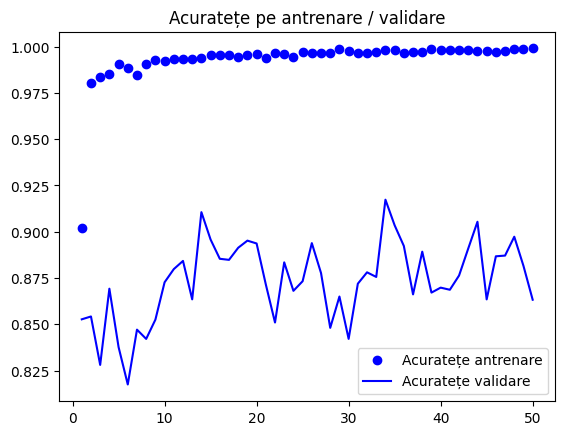

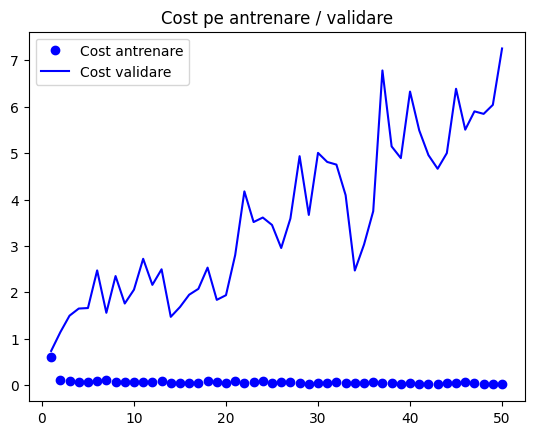

In [12]:
history = np.load('asdxs.history.npy', allow_pickle=True).item()

accuracy = history["accuracy"]
val_accuracy = history["val_accuracy"]
loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Acuratețe antrenare")
plt.plot(epochs, val_accuracy, "b", label="Acuratețe validare")
plt.title("Acuratețe pe antrenare / validare")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Cost antrenare")
plt.plot(epochs, val_loss, "b", label="Cost validare")
plt.title("Cost pe antrenare / validare")
plt.legend()
plt.show()

In [13]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [14]:
model.compile(loss="categorical_crossentropy",
                 optimizer=Adam(learning_rate=0.0001),
                 metrics=["accuracy"])

In [15]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath = 'fw.model.keras',
                                             save_best_only=True,
                                             monitor="val_loss")]

history = model.fit(train_features, train_labels,
                    epochs=50,
                    validation_data=(val_features, val_labels),
                    callbacks=callbacks)

np.save('few.history.npy', history.history)

Epoch 1/50
488/488 [==============================] - 2s 4ms/step - loss: 0.0180 - accuracy: 0.9992 - val_loss: 6.8551 - val_accuracy: 0.8702
Epoch 2/50
488/488 [==============================] - 2s 4ms/step - loss: 0.0126 - accuracy: 0.9991 - val_loss: 6.1997 - val_accuracy: 0.8790
Epoch 3/50
488/488 [==============================] - 2s 5ms/step - loss: 0.0127 - accuracy: 0.9996 - val_loss: 5.1719 - val_accuracy: 0.8863
Epoch 4/50
488/488 [==============================] - 3s 6ms/step - loss: 0.0097 - accuracy: 0.9997 - val_loss: 4.8217 - val_accuracy: 0.8881
Epoch 5/50
488/488 [==============================] - 3s 6ms/step - loss: 0.0055 - accuracy: 0.9996 - val_loss: 4.7920 - val_accuracy: 0.8829
Epoch 6/50
488/488 [==============================] - 3s 6ms/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 4.6966 - val_accuracy: 0.8871
Epoch 7/50
488/488 [==============================] - 3s 6ms/step - loss: 0.0050 - accuracy: 0.9997 - val_loss: 4.8650 - val_accuracy: 0.8860
Epoch 

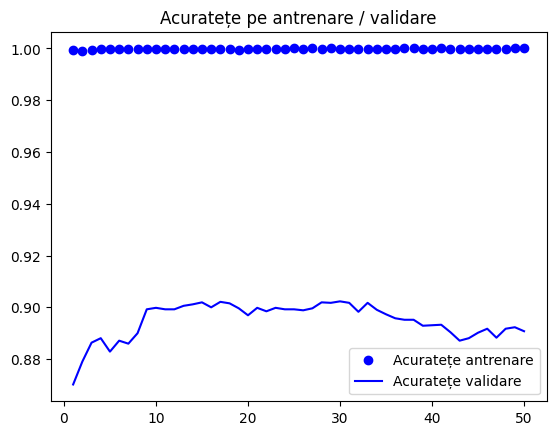

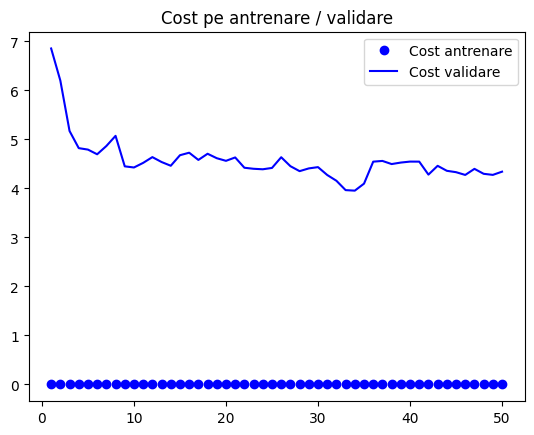

In [16]:
history = np.load('few.history.npy', allow_pickle=True).item()

accuracy = history["accuracy"]
val_accuracy = history["val_accuracy"]
loss = history["loss"]
val_loss = history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Acuratețe antrenare")
plt.plot(epochs, val_accuracy, "b", label="Acuratețe validare")
plt.title("Acuratețe pe antrenare / validare")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Cost antrenare")
plt.plot(epochs, val_loss, "b", label="Cost validare")
plt.title("Cost pe antrenare / validare")
plt.legend()
plt.show()

In [ ]:
load_model = keras.models.load_model(MODEL_SAVE_DIR / f'{SAVE_NAME}.model.h5')
load_model.summary()

## EVALUATION

In [24]:
test_model = keras.models.load_model('VGG16.model.h5')
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

TypeError: weight_decay is not a valid argument, kwargs should be empty  for `optimizer_experimental.Optimizer`.

In [17]:
# test_model = keras.models.load_model(f'{SAVE_NAME}.model.keras')
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

163/163 [==============================] - 1s 5ms/step - loss: 5.7068 - accuracy: 0.8627
Test accuracy: 0.863


In [18]:
y_pred = np.argmax(model.predict(test_features), axis=-1)
y_true = np.argmax(test_labels, axis=-1)
print(classification_report(y_true, y_pred, target_names=test_dataset.class_names))

163/163 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           A       0.67      1.00      0.80       200
           B       0.83      0.84      0.84       200
           C       1.00      1.00      1.00       200
           D       0.99      0.56      0.72       200
           E       1.00      0.43      0.60       200
           F       0.99      0.97      0.98       200
           G       0.99      0.96      0.98       200
           H       0.97      1.00      0.98       200
           I       0.89      0.79      0.84       200
           K       0.98      0.98      0.98       200
           L       0.98      1.00      0.99       200
           M       0.49      0.68      0.57       200
           N       0.33      0.14      0.20       200
           O       0.80      1.00      0.89       200
           P       0.94      0.98      0.96       200
           Q       1.00      0.97      0.98       200
           R       0.90   

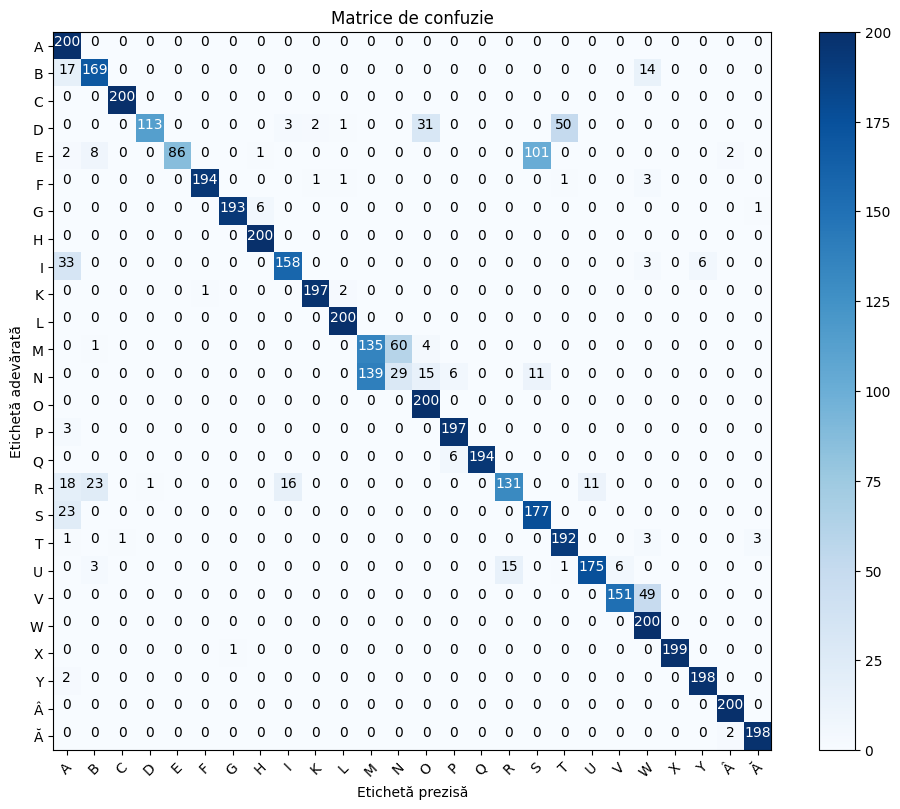

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matrice de confuzie')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etichetă adevărată')
    plt.xlabel('Etichetă prezisă')

plot_confusion_matrix(y_true, y_pred, classes=test_dataset.class_names)
plt.show()